# Modern Hopfield Model

More similar to the monte carlo updating. There is a certain energy function. Make a trial flip, calculate energy before and after, choose the spin the minimizes the energy.

In [764]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = 'white'
import scipy.interpolate as interpolate
import scipy.stats
from scipy.signal import savgol_filter
from tqdm import tqdm

In [558]:
@njit
def random_config(L, prob=0.5):
    """ Creates a random array of spins with values +1 and -1. Default probability is 0.5 for +1. 
        L: Length of array of spins
    """
    array =  np.ones(L)
    for i in range(L):
        r = np.random.uniform(0,1)
        if r>prob:
            array[i] *= -1

    return array

@njit
def random_config_cont(L):
    """ Creates a random array of spins with values from 0 to -1. 
        L: Length of array of spins
    """
    array =  np.ones(L)
    for i in range(L):
        array[i] = np.random.uniform(0,1)-0.5
    return array

def Heaviside_arr(x_arr):
    result_arr = np.zeros_like(x_arr)
    for i in range(len(x_arr)):
        if x_arr[i]>= 0:
            result_arr[i] = 1
        else:
            result_arr[i] = 0
    return result_arr

@njit
def Heaviside(x):
    if x>=0:
        return 1
    else:
        return 0

## Polynomial F

In [618]:
@njit
def p_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros(p)
    for i in range(p):
        m_arr[i] = 1/L * np.sum(spins*pattern[i])
    return m_arr

@njit
def mh_energy(pattern, spins, n):
    p, L = np.shape(pattern)
    E = 0
    for i in range(0,p):
        arr = np.sum(spins*pattern[i])
        E += arr**n
    E *= -1
    return E

@njit
def mh_sweep(pattern, spins, T, n):
    p, L = np.shape(pattern)
    for j in range(0,L):
        rdm_spin = int(np.random.uniform(0,1)*L)
        trial_spins = spins.astype(np.int32)
        trial_spins[rdm_spin] *= -1
        dE = mh_energy(pattern, trial_spins, n) - mh_energy(pattern, spins, n)
        if dE<=0:
            spins[rdm_spin] *= -1
            return spins
        else:
            r = np.random.uniform(0,1)
            if r<np.exp(-dE/T):
                spins[rdm_spin] *= -1
                return spins
            else:
                return spins

@njit
def mh_run(pattern, T, N, n):
    p, L = np.shape(pattern)
    initial_spins = random_config(L)

    spins = np.copy(initial_spins)
    H_arr = np.zeros(N+1)
    H_arr[0] = mh_energy(pattern, spins, n)
    overlaps = np.zeros((N+1, p))
    overlaps[0] = p_overlap(spins, pattern)

    spins_history = np.zeros((N+1, L))
    spins_history[0] = np.copy(spins)

    for run in range(N):
        spins = mh_sweep(pattern, spins, T, n)
        H_arr[run+1] = mh_energy(pattern, spins, n)
        overlaps[run+1] = p_overlap(spins, pattern)
        spins_history[run+1] = spins.astype(np.int32)
        
    return spins_history, pattern, H_arr, overlaps

## INITIAL TEST

Number of patterns: 500
Matched with pattern number 417


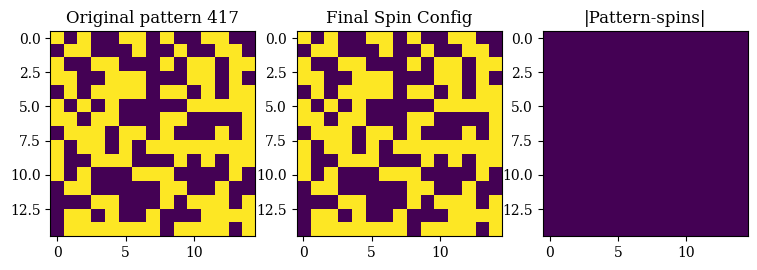

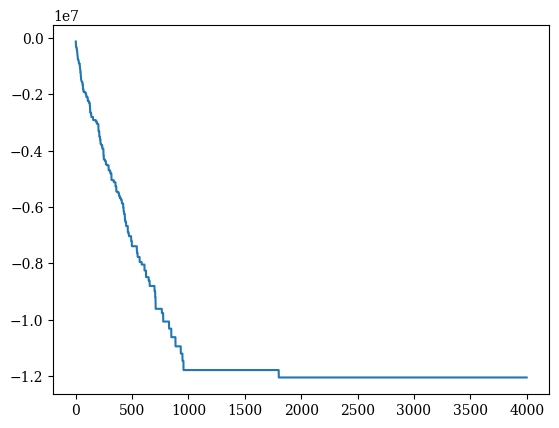

CPU times: user 2.64 s, sys: 38.3 ms, total: 2.68 s
Wall time: 2.35 s


In [720]:
%%time
sqr = 15; L = sqr**2
num_pat = 500
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr =  np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = random_config(L)

spins_history, pattern, H_arr, overlaps = mh_run(pattern=pat_arr, T=0.01, N=4_000, n=3)

spins = spins_history[-1]
match = 0
for i in range(num_pat):
    if all(spins==pattern[i]) or all(-spins==pattern[i]):
        print("Matched with pattern number", i+1)
        match = i+1
        break
if match == 0:
    print("Failed!")
        
    
spins_grid = spins.reshape(sqr,sqr)
pattern_grid = pattern[i].reshape(sqr,sqr)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
ax[0].imshow(pattern_grid)
ax[0].set_title("Original pattern "+str(match))
ax[1].imshow(spins_grid)
ax[1].set_title("Final Spin Config")
ax[2].imshow(abs(pattern_grid+spins_grid))
ax[2].set_title("|Pattern-spins|")
plt.show()

plt.plot(H_arr)
plt.show()

## CHECKING CAPACITY FOR ONE VALUE OF N

In [574]:
%%time
sqr = 10
L = sqr**2
N_sweeps = 2000
N_avg = 100
num_pat_arr = np.linspace(1, 50*L, 10).astype(np.int64)
n_pattern = np.zeros_like(num_pat_arr)
n_inverse = np.zeros_like(num_pat_arr)
n_spurious = np.zeros_like(num_pat_arr)
energy_arr = np.zeros(shape=(len(num_pat_arr), N_sweeps+1))

for npa in tqdm(range(0, len(num_pat_arr))):
    num_pat = num_pat_arr[npa]

    for avg_no in range(0, N_avg):
        # creating random patterns
        pat_arr =  np.ones((num_pat,L))
        for j in range(num_pat):
            pat_arr[j] = random_config(L)  
        
        spins_history, pattern, H_arr, overlaps = mh_run(pattern=pat_arr, T=0.01, N=N_sweeps, n=5)
        spins = spins_history[-1]
        energy_arr[npa] += H_arr/N_avg
        
        match = 0
        for i in range(num_pat):
            if all(spins==pattern[i]): 
                n_pattern[npa] += 1
                match = i+1
                break
            elif all(-spins==pattern[i]):
                n_inverse[npa] += 1
                match = i+1
        if match == 0:
            n_spurious[npa] +=1

n_pattern = n_pattern/N_avg
n_inverse = n_inverse/N_avg
n_spurious = n_spurious/N_avg

100%|██████████████████████████████████████████| 10/10 [51:52<00:00, 311.27s/it]

CPU times: user 51min 37s, sys: 22 s, total: 51min 59s
Wall time: 51min 52s


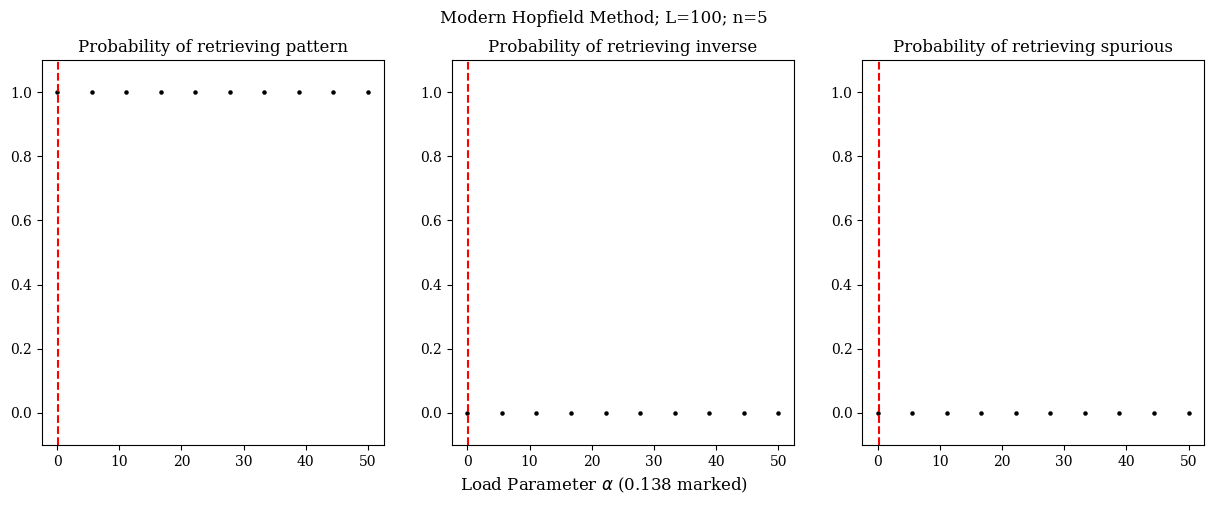

In [575]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
ax[0].scatter(num_pat_arr/L, n_pattern, s=5, color='black')
ax[0].axvline(x=0.138, color='red', ls='--')
ax[0].set_title('Probability of retrieving pattern')
ax[1].scatter(num_pat_arr/L, n_inverse, s=5, color='black')
ax[1].axvline(x=0.138, color='red', ls='--')
ax[1].set_title('Probability of retrieving inverse')
ax[2].scatter(num_pat_arr/L, n_spurious, s=5, color='black')
ax[2].axvline(x=0.138, color='red', ls='--')
ax[2].set_title('Probability of retrieving spurious')
fig.supxlabel(r'Load Parameter $\alpha$ (0.138 marked)')
plt.setp(ax, ylim=(-0.1,1.1))
fig.suptitle("Modern Hopfield Method; L=100; n=5")
plt.show()

## CHECKING CAPACITY ACROSS N

In [701]:
@njit
def temp_func(num_pat, L):
    pat_arr =  np.ones((num_pat,L))
    for j in range(num_pat):
        pat_arr[j] = random_config(L)  
    
    spins_history, pattern, H_arr, overlaps = mh_run(pattern=pat_arr, T=0.01, N=3_000, n=3)
    spins = spins_history[-1]
    
    match = 0; n_pattern = 0; n_inverse = 0; n_spurious = 0
    for i in range(num_pat):
        if np.all(spins==pattern[i]): 
            n_pattern = 1
            match = i+1
            break
        elif np.all(-spins==pattern[i]):
            n_inverse = 1
            match = i+1
    if match == 0:
        n_spurious = 1

    return n_pattern, n_inverse, n_spurious

In [702]:
%%time
L_arr = np.arange(150, 210, 10)
N_avg = 100
N_points = 20
capacity = np.zeros_like(L_arr)
n_pattern_overall = np.zeros((len(L_arr),N_points))
num_pat_overall = np.zeros_like(n_pattern_overall)

for size in tqdm(range(len(L_arr))):
    L = L_arr[size]
    num_pat_arr = np.linspace(50, 1500, N_points).astype(np.int32)
    n_pattern = np.zeros_like(num_pat_arr)
    n_inverse = np.zeros_like(num_pat_arr)
    n_spurious = np.zeros_like(num_pat_arr)
    
    for npa in range(0, len(num_pat_arr)):
        num_pat = num_pat_arr[npa]
        for avg_no in range(0, N_avg):
            pattern, inverse, spurious = temp_func(num_pat, L)
            n_pattern[npa] += pattern; n_inverse[npa] += inverse; n_spurious[npa] += spurious
    
    n_pattern = (n_pattern+n_inverse)/N_avg
    n_pattern_overall[size] = n_pattern
    num_pat_overall[size] = num_pat_arr

100%|████████████████████████████████████████| 6/6 [10:59:06<00:00, 6591.15s/it]

CPU times: user 6h 24min 22s, sys: 1min 56s, total: 6h 26min 19s
Wall time: 10h 59min 6s


In [703]:
# A = np.zeros((3, len(L_arr), N_points))
# A[0][:,0] = L_arr
# # A[0][:,1] = capacity_arr_alt
# A[1] = num_pat_overall
# A[2] = n_pattern_overall
# np.save('ModernHopfield_Capacity_data_4', A)

In [704]:
# a = np.load('ModernHopfield_Capacity_data_2&3.npy')
# b = np.load('ModernHopfield_Capacity_data_4.npy')
# a[1][-6:] = b[1]
# a[2][-6:] = b[2]
# np.save('ModernHopfield_Capacity_data_2&4', a)

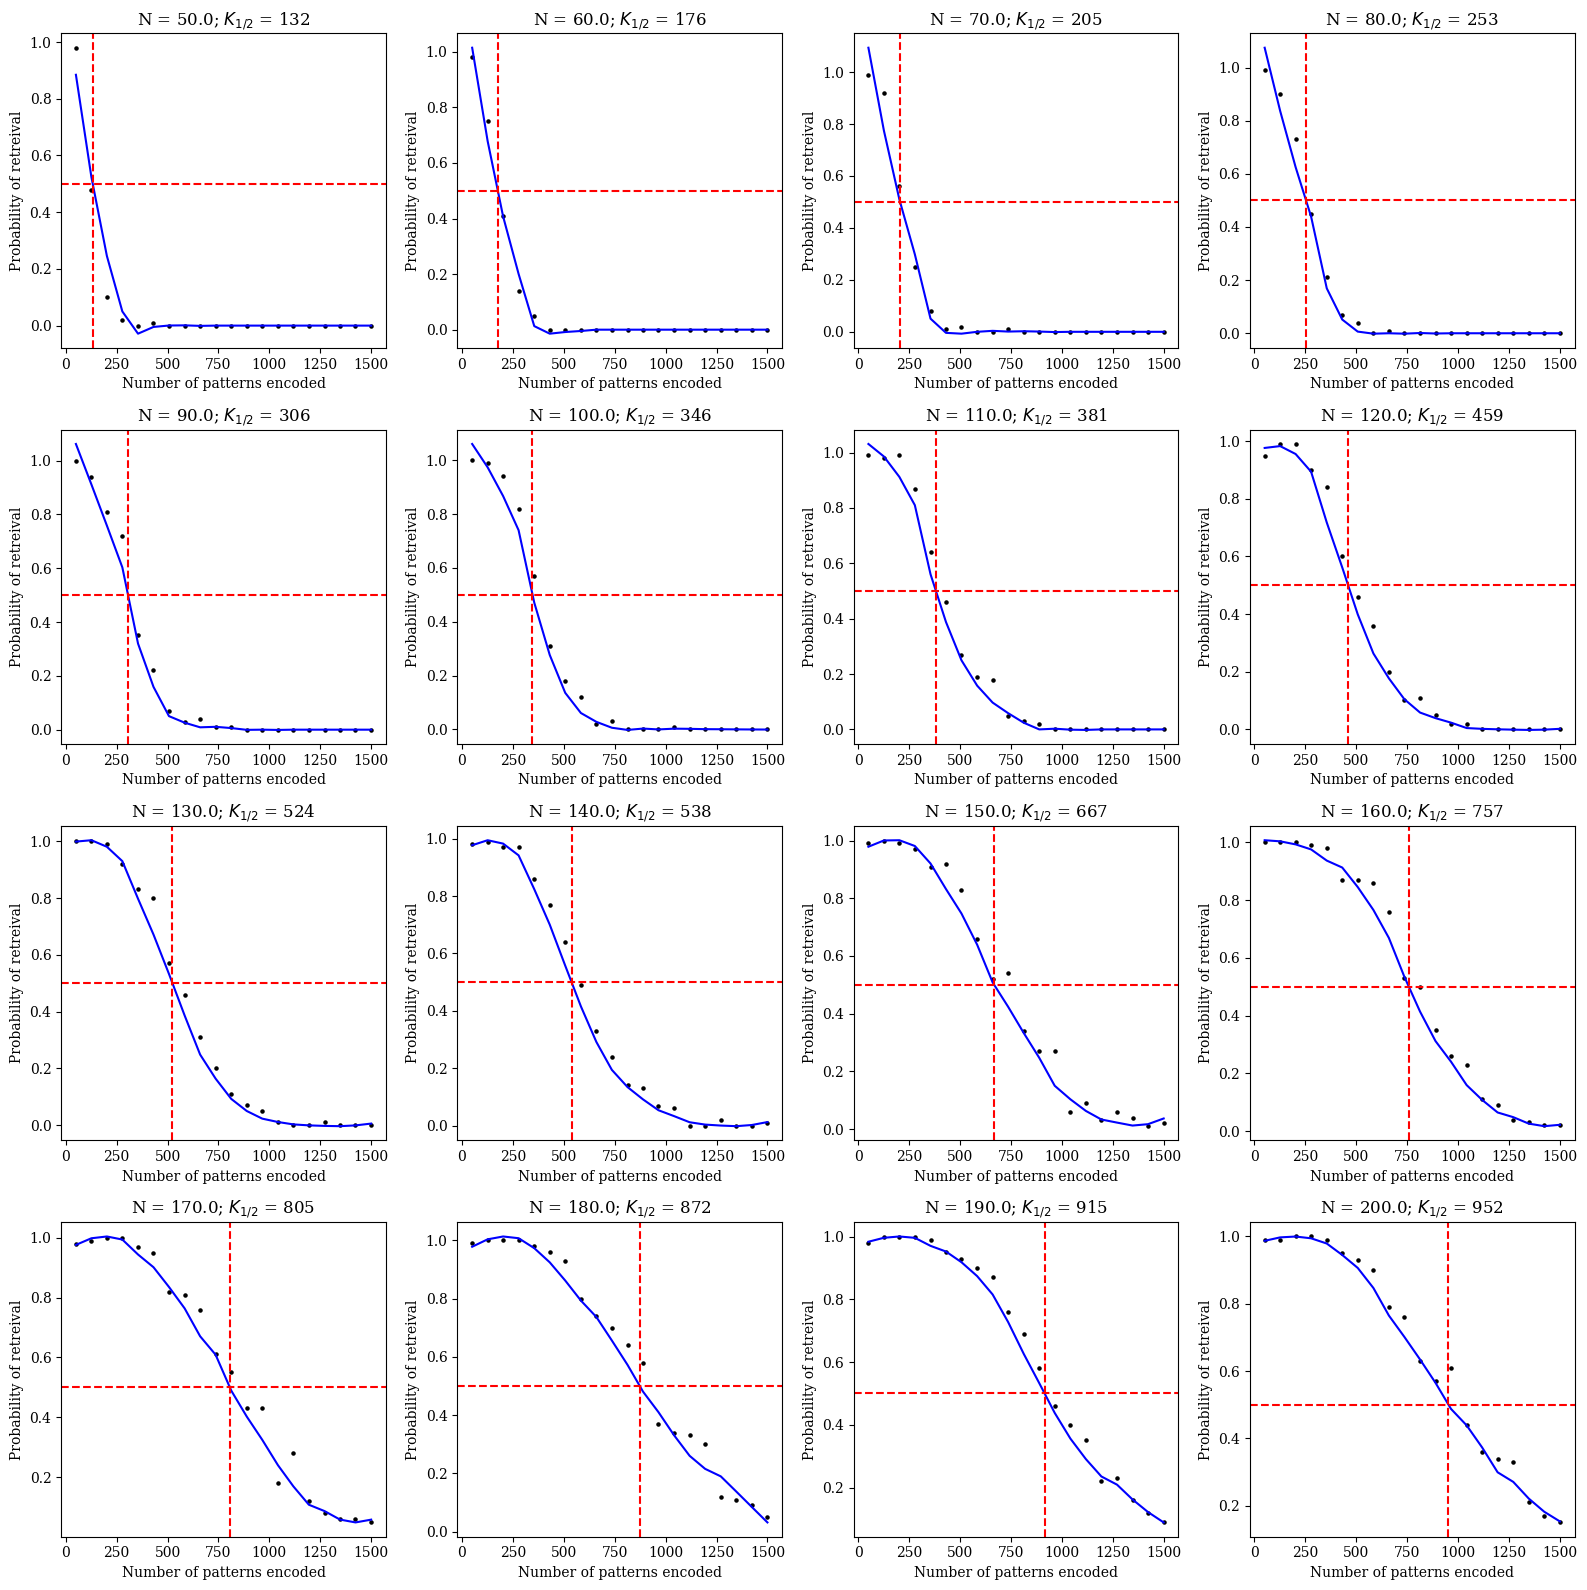

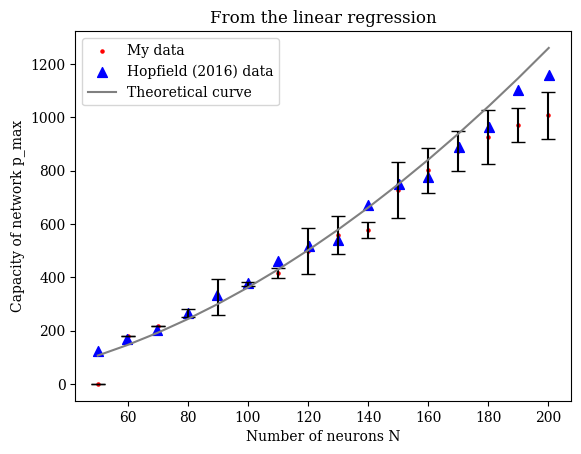

[  0.         0.         0.        15.649767  66.93733    6.85955
  18.052624  86.04911   72.17223   29.072508 105.31827   84.92752
  76.00495  101.86394   64.11971   87.8237  ]


In [979]:
B = np.load('ModernHopfield_Capacity_data_2&4.npy')
num_pat_overall = B[1]
n_pattern_overall = B[2]
L_arr = B[0][:,0]

L, pat = np.shape(n_pattern_overall)
fig, ax = plt.subplots(nrows=int(np.ceil(L/4)), ncols=4, figsize=(16,16))


K_half = np.zeros(len(L_arr), dtype=np.int32)
K_half_alt = np.zeros(len(L_arr), dtype=np.int32)
K_half_err = np.zeros(len(L_arr), dtype=np.float32)
for i in range(int(np.ceil(L/4))):
    for j in range(4):

        L_spec = L_arr[i*4 + j]
        ax[i,j].scatter(num_pat_overall[i*4 + j], n_pattern_overall[i*4 + j], s=5, color='black')
        n_pattern_smooth = savgol_filter(n_pattern_overall[i*4 + j], window_length=8, polyorder=2)
        f_pattern = interpolate.interp1d(x=num_pat_overall[i*4+j], y=n_pattern_smooth, kind='cubic')
        ax[i,j].plot(num_pat_overall[i*4+j], f_pattern(num_pat_overall[i*4+j]), color='blue')

        ax[i,j].axhline(y=0.5, color='red', ls='--')
        b = np.diff(n_pattern_smooth)
        x_arr = n_pattern_smooth[:len(b[b!=0]) + 1]
        y_arr = num_pat_overall[i*4+j][:len(b[b!=0]) + 1]
        f_inv = interpolate.interp1d(x=x_arr, y=y_arr, kind='linear')
        K_half[i*4 + j] = f_inv(0.5)
        ax[i,j].axvline(x=K_half[i*4 + j], color='red', ls='--')
        
        ax[i,j].set_xlabel(r'Number of patterns encoded')
        ax[i,j].set_ylabel('Probability of retreival')
        ax[i,j].set_title(r'N = '+str(L_spec)+'; $K_{1/2}$ = '+str(K_half[i*4+j]))

        probabilities = n_pattern_overall[i*4 + j]
        pattern_num = num_pat_overall[i*4+j]
        cut_prob = probabilities[(0.2<probabilities) * (probabilities<0.9)]
        cut_pat = pattern_num[(0.2<probabilities) * (probabilities<0.9)]
        result = scipy.stats.linregress(cut_pat, cut_prob)
        m = result.slope; c = result.intercept; m_err = result.stderr; c_err = result.intercept_stderr
        y = np.arange(0.9, 0.2, -0.01)
        x = (y-c)/m
        if i*4 + j >0:
            K_half_alt[i*4 + j] = (0.5 - c)/m
            # K_half_err[i*4 + j] = abs(int((0.5 - (c+c_err))/(m-m_err)) - int((0.5 - c)/m))
            K_half_err[i*4 + j] = np.sqrt((m_err/m)**2 + (c_err/c)**2) * (0.5 - c)/m
        # ax[i,j].plot(x, y, color='black')

plt.tight_layout()
plt.show()

# plt.scatter(L_arr, K_half, color='red', s=5, label='My data')
# plt.xlabel('Number of neurons N')
# plt.ylabel('Capacity of network p_max')
x, y = np.loadtxt("Hopfield_2016.csv", delimiter=',', unpack=True)
# plt.scatter(x,y, s=10, color='blue', label='Hopfield (2016) data', marker='^', facecolors=None)
# plt.plot(x, x**2 / np.log(x) / 6, color='grey', label='Theoretical curve')
# plt.legend()
# plt.title('From the Interpolation')
# plt.show()

plt.scatter(L_arr, K_half_alt, color='red', s=5, label='My data')
plt.errorbar(x=L_arr, y=K_half_alt, yerr=K_half_err, ls=' ', color='black', capsize=5)
plt.xlabel('Number of neurons N')
plt.ylabel('Capacity of network p_max')
plt.scatter(x,y, s=50, color='blue', label='Hopfield (2016) data', marker='^', facecolors=None)
plt.plot(x, x**2 / np.log(x) / 6, color='grey', label='Theoretical curve')
plt.legend()
plt.title('From the linear regression')
plt.show()
print(K_half_err)

In [831]:
a = np.array([2,3,1,5,2,7])
result_arr = scipy.stats.linregress([1,4,5], [2,1, 0])
print(result_arr)

LinregressResult(slope=-0.46153846153846145, intercept=2.5384615384615383, rvalue=-0.9607689228305227, pvalue=0.17891237502206694, stderr=0.13323467750529838, intercept_stderr=0.49851851526214364)


## Hopfield and Krotov 2020

In [972]:
@njit
def sign(x):
    if x>= 0:
        return 1
    else:
        return -1

In [973]:
@njit
def hk2020_sweep(spins, hidden, pattern, T):
    N = len(spins)
    M = len(hidden)
    for mu in range(M):
        hidden[mu] = np.tanh(np.sum(pattern[mu] * spins)/T)
    for i in range(N):
        spins[i] = np.tanh(np.sum(pattern[:,i] * (2*hidden))/T)
    return spins, hidden
    
@njit
def hk2020_run(pattern, T, sweeps=1_000):
    """
    pattern: Array of sequence patterns to be retrived in order
    T: Temperature of the system
    """
    p, N = np.shape(pattern)
    M = p
    
    spins = random_config_cont(N)
    hidden = random_config_cont(M)
    
    H_arr = np.zeros(sweeps+1)
    H_arr[0] = mh_energy(pattern, spins, 2)
    overlaps = np.zeros((sweeps+1, p))
    overlaps[0] = p_overlap(spins, pattern)
    spins_history = np.zeros((sweeps+1, N))
    spins_history[0] = np.copy(spins)
    print(spins_history.dtype)

    for run in range(sweeps):
        spins, hidden = hk2020_sweep(spins, hidden, pattern, T)
        H_arr[run+1] = mh_energy(pattern, spins, 2)
        overlaps[run+1] = p_overlap(spins, pattern)
        spins_history[run+1] = np.copy(spins)
        
    return spins_history, pattern, H_arr, overlaps

In [976]:
sqr = 10
N = sqr**2
p = 5
pat_arr =  np.ones((p,N))
for j in range(p):
    pat_arr[j] = random_config(N)

spins_history, pattern, H_arr, overlaps = hk2020_run(pat_arr, T=0.001, sweeps=1000)

float64


Failed!


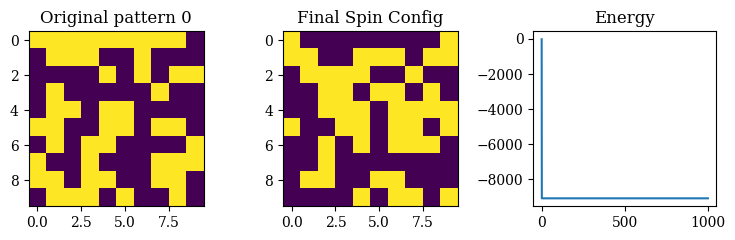

In [977]:
spins = spins_history[-1]
match = 0
for i in range(p):
    if all(spins==pattern[i]) or all(-spins==pattern[i]):
        print("Matched with pattern number", i+1)
        match = i+1
        break
if match == 0:
    print("Failed!")
        
    
spins_grid = spins.reshape(sqr,sqr)
pattern_grid = pattern[i].reshape(sqr,sqr)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7.5,2.5))
ax[0].imshow(pattern_grid)
ax[0].set_title("Original pattern "+str(match))
ax[1].imshow(spins_grid)
ax[1].set_title("Final Spin Config")
ax[2].plot(H_arr)
ax[2].set_title('Energy')
plt.tight_layout()
plt.show()

In [ ]:
#continuous with differential equation